In [14]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pykrige as pk
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression

In [28]:
dat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')

In [7]:
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


## バリオグラム推定

### バリオグラム雲
- packageに実装なし
- 別途調査・実装

### 経験バリオグラム

## Regression kriging
- pykrige packageのRegression krigingはsklearnのモデルのみ受け取る
- バリオグラム単体を表示・操作するクラスはなく, krigingクラスにvariogramの操作機能が包括されている

In [8]:
model = LinearRegression(fit_intercept=False)

In [29]:
def transform_data(data, columns_latlon, columns_indep):
    '''
    Change the data format to use in kriging
    Input: list of columns:latlon and independent variable
    Output: values in np.array
    '''
    latlon = data[columns_latlon].values
    indeps = data[columns_indep].values
    return latlon, indeps

In [30]:
latlon, prop = transform_data(dat, ['px', 'py'], ['station', 'tokyo'])
mlatlon, mprop = transform_data(mdat, ['px', 'py'], ['station', 'tokyo'])
y = dat['price'].apply(lambda x: np.log(x)).values

In [12]:
y

array([11.9381932 , 12.05524976, 12.28765263, 12.06104687, 12.01370075,
       12.15477935, 12.14950229, 12.23076526, 12.4874851 , 12.41714362,
       12.18075484, 12.01974307, 12.34147728, 12.03171926, 12.14950229,
       12.23076526, 12.35879373, 12.13350195, 12.1388639 , 12.20607265,
       11.81303006, 12.2010601 , 12.25486281, 12.33710091, 12.08390501,
       12.3327053 , 11.91839057, 12.18075484, 12.30591798, 12.17561344,
       12.44114477, 12.46071486, 12.15477935, 11.94470788, 12.35449265,
       12.29682701, 12.14950229, 12.56723749, 12.60819885, 12.10625231,
       12.16525065, 12.16525065, 12.60148742, 12.02574909, 12.00150548,
       11.9381932 , 12.86876062, 12.23076526, 12.08390501, 12.00150548,
       12.38002595, 11.71993963, 12.19602231, 12.63785506, 12.38002595,
       12.00762171, 12.21602298, 11.89818787, 12.79107767, 12.02574909,
       12.26904744, 12.18586994, 12.6791964 , 11.97035031, 12.40081672,
       12.7628272 , 12.16525065, 11.9511804 , 12.39669301, 11.87

In [31]:
from pykrige.rk import RegressionKriging
gmodel = RegressionKriging(regression_model=model,  variogram_model='exponential', nlags=15)

In [32]:
gmodel.fit(prop, latlon, y)

Finished learning regression model
Finished kriging residuals


In [33]:
my = gmodel.predict(mprop, mlatlon)
print(my)

[12.63291266 12.23845812 11.87260946 11.6689488  13.23492107 12.87736253
 12.66492093 12.26097668 11.88436102 11.62359781 11.53878428 11.58319791
 11.80894766 11.89203102 11.90733777 11.81242483 11.97584795 11.73073961
 11.74825965 11.78803024 11.91669121 12.0314618  11.97788051 11.96561484
 11.97168956 11.8358395  11.87262235 11.89394267 12.05556529 11.9781703
 11.94714832 11.99630178 11.93880805 12.04955993 11.96499049 11.94955143
 11.94532416 11.99272049 11.99705217 11.99134327 12.05757367 12.09431199
 12.1115346  11.95277379 11.97987771 12.04733982 12.0331345  11.98930763
 12.07922454 12.07167762 12.07955801 12.07453368 12.18144358 12.06129242
 12.10288681 12.21309819 12.23836073 12.17526537 12.19878952 12.23575655
 12.16596551 12.13295504 12.61731533 12.12674875 12.16258422 12.26295404
 12.3523282  12.30576674 12.30747109 12.26517632 12.20359111 12.19413337
 12.77771802 12.41234934 12.13604063 12.12456389 12.24004112 12.39075863
 12.36667458 12.19737808 12.25385783 12.3651574  12.

In [34]:
def loo_cv(mod, dat, target, latlon, indep):
    '''
    perform the LOO cross validation by kriging model
    input: kriging model, data(df), column names of dep var, latlon, indep var
    output: the result of cv
    '''
    # LOO cross validation
    pred_list = []
    for i in range(0,len(dat)):
        dsub = dat.drop(i)
        msub = dat.iloc[i:i+1, :]

        dprop = dsub[indep].values
        dlatlon = dsub[latlon].values
        dy = dsub[target].apply(lambda x: np.log(x)).values

        m_prop = msub[indep].values
        m_latlon = msub[latlon].values
        gmodel.fit(dprop, dlatlon, dy)
        pred = gmodel.predict(m_prop, m_latlon)
        pred_list.append(pred)
    return pred_list

In [35]:
pred_list = loo_cv(gmodel, dat, 'price', ['px', 'py'], ['station', 'tokyo'])

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [36]:
len(pred_list)

128

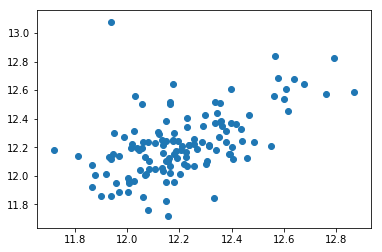

In [37]:
plt.scatter(y, pred_list)
plt.ylim = (11.8, 12.8)
plt.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/res_pykrige.png')
plt.show()

In [38]:
mdat['price'] = my

In [39]:
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,12.632913,0.017537,0.374249
1,139.407036,35.767626,12.238458,0.013571,0.370307
2,139.411089,35.767626,11.872609,0.009675,0.366367
3,139.439457,35.767626,11.668949,0.001584,0.338865
4,139.394878,35.763700,13.234921,0.026327,0.381271


In [47]:
def transform_to_gpd(df, lat ,lon):
    '''
    transform the dataframe to the geodataframe
    input:dataframe, column names of longitude and latitude
    output: geo dataframe
    '''
    df['Coordinates'] = list(zip(df['px'], df['py']))
    df['Coordinates'] = df['Coordinates'].apply(Point)
    gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')
    return gdf

In [48]:
gmdat = transform_to_gpd(mdat, 'px', 'py')

In [49]:
mdat.head()

,px,py,price,station,tokyo,Coordinates
0,139.402984,35.767626,12.632913,0.017537,0.374249,POINT (139.4029835 35.7676260119048)
1,139.407036,35.767626,12.238458,0.013571,0.370307,POINT (139.4070361 35.7676260119048)
2,139.411089,35.767626,11.872609,0.009675,0.366367,POINT (139.4110887 35.7676260119048)
3,139.439457,35.767626,11.668949,0.001584,0.338865,POINT (139.4394569 35.7676260119048)
4,139.394878,35.763700,13.234921,0.026327,0.381271,POINT (139.3948783 35.76370003571429)


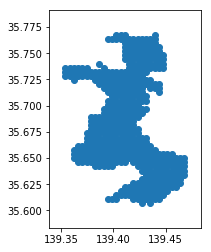

In [26]:
gmdat.plot()

In [51]:
np.linspace(gmdat['price'].min(), gmdat['price'].max(), 10)

array([11.53878428, 11.72724393, 11.91570357, 12.10416321, 12.29262286,
       12.4810825 , 12.66954214, 12.85800179, 13.04646143, 13.23492107])

In [52]:
def set_rang(data, column, num):
    max_val = data[column].max()
    min_val = data[column].min()
    rang = np.linspace(min_val, max_val, num=num)
    return rang

In [53]:
rang = set_rang(gmdat, 'price', 10)

In [54]:
gmdat_list = []
for i in range(0, len(rang)):
    if i< len(rang)-1:
        g = gmdat[(gmdat['price'] >= rang[i]) & (gmdat['price'] < rang[i+1])]
    else:
        g = gmdat[gmdat['price'] >= rang[i]]
    gmdat_list.append(g)

In [55]:
color_list = [str(round(x,2)) for x in np.linspace(0.1, 0.9, len(rang))]

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
for i in range(0, len(gmdat_list)):
    gmdat_list[i].plot(ax=ax, color = color_list[i], marker='s', markersize = 170)
ax.legend(['[{0}, {1})'.format(rang[i], rang[i+1]) for i in range(0, len(rang)-1)],loc='upper left')

In [59]:
def plot_kriging_res(gmdat, column, rang):
    ''''
    '''
    color_list = [str(round(x,2)) for x in np.linspace(0.1, 0.9, len(rang))]
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    for i in range(0, len(rang)):
        if i< len(rang)-1:
            g = gmdat[(gmdat[column] >= rang[i]) & (gmdat[column] < rang[i+1])]
        else:
            g = gmdat[gmdat[column] >= rang[i]]
        g.plot(ax=ax, color = color_list[i], marker='s', markersize=170)
    ax.legend(['[{0}, {1})'.format(rang[i], rang[i+1]) for i in range(0, len(rang)-1)],loc='center left', bbox_to_anchor=(1, 0.5))

    return fig

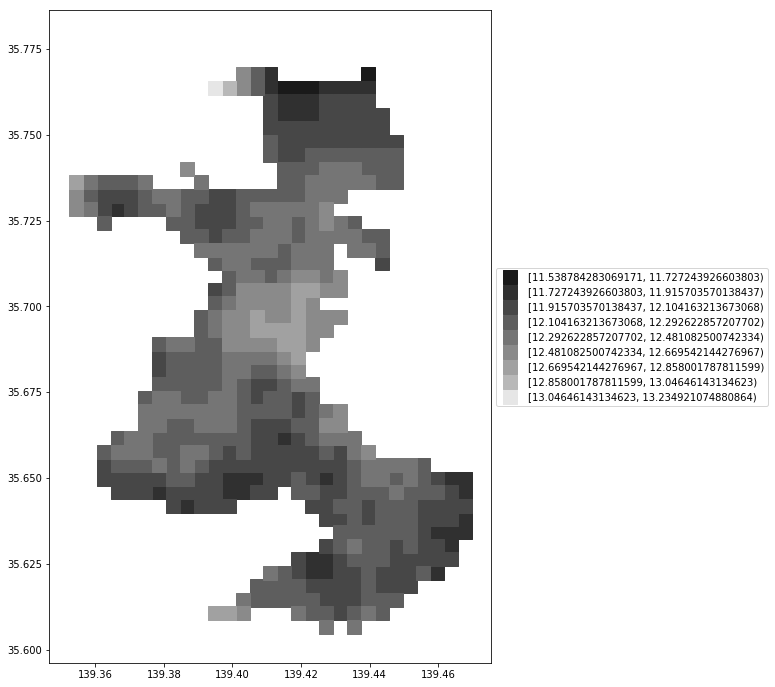

In [60]:
res_fig = plot_kriging_res(gmdat, 'price', rang)

In [1]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_res_plot.png')

NameError: name 'res_fig' is not defined

## 残差の2乗をプロットする
期待二乗誤差?

In [61]:
gmdat['sq_resid'] = gmodel.krige_residual(mlatlon)**2

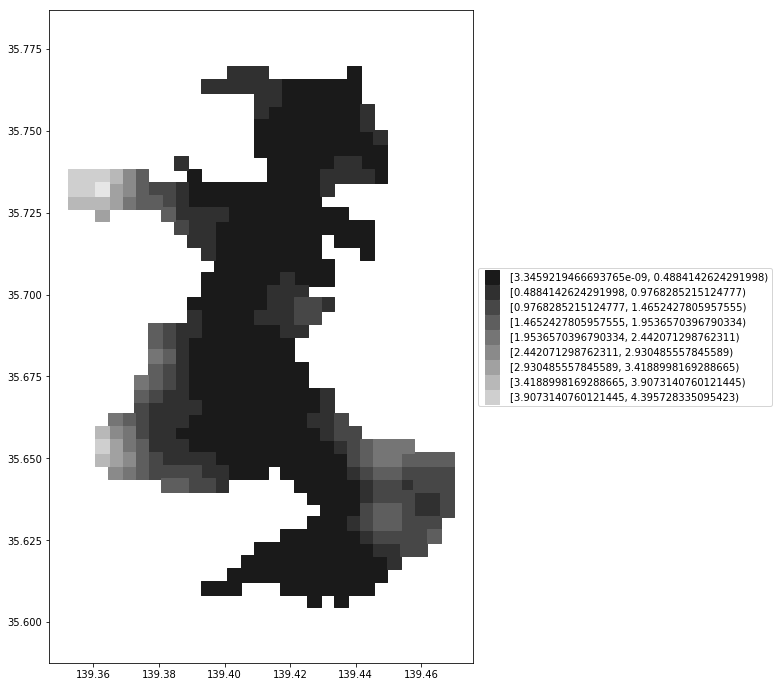

In [62]:
rang = set_rang(gmdat, 'sq_resid', 10)
sq_resid_fig = plot_kriging_res(gmdat, 'sq_resid', rang)

In [ ]:
sq_resid_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_resid_plot.png')